## Load Libraries

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

#Part3
from scipy import stats
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import LabelBinarizer, StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

## Load Data

In [2]:
logins = pd.read_json('logins.json')

In [3]:
logins.shape

(93142, 1)

In [4]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


The logins dataframe is 1 column with 93,142 entries all in datetime format.

In [5]:
challenge_file = open('ultimate_data_challenge.json', mode='r')
challenge_df = challenge_file.read()
challenge_file.close()
challenge = json.loads(challenge_df)
challenge = pd.DataFrame(challenge)

In [6]:
challenge.shape

(50000, 12)

In [7]:
challenge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


The challenge dataframe is 12 features and 50,000 entries in various dtypes. It appears as well to have missing features for 3 of the features.

# Part 1: Exploratory Data Analysis

### Step 1:   Aggregate these login counts based on 15 minute time intervals.

In [8]:
logins.set_index('login_time', inplace=True)
logins['counts'] = 1
logins.sort_index(inplace=True)
logins = logins.resample('15T').sum()
logins.head()

,counts
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


### Step 2: Visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand.

In [9]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9788 entries, 1970-01-01 20:00:00 to 1970-04-13 18:45:00
Freq: 15T
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   counts  9788 non-null   int64
dtypes: int64(1)
memory usage: 152.9 KB


The data begins January 1 and goes through April 13 of the year 1970. There are 9788 entries in one column called `counts`. Since there 9,788 entries its impratical to plot all entries at once. Therefore, let's breakup the data into small time segments.

In [10]:
monthly = logins.resample('1M', label='left').sum()
monthly

,counts
login_time,
1969-12-31,21239
1970-01-31,24673
1970-02-28,33723
1970-03-31,13507


There are four months in the data: Jan, Feb, Mar, and Apr. February has the highest count and March the lowest.

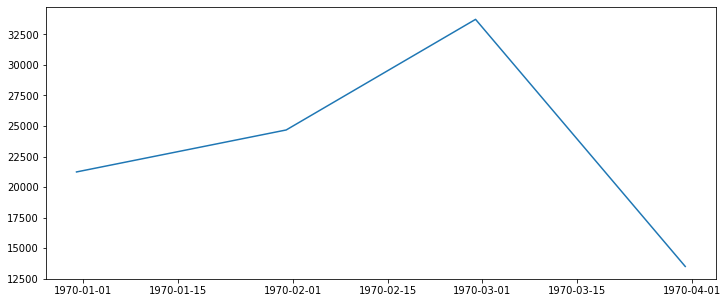

In [11]:
plt.figure(figsize=(12, 5))
plt.plot(monthly)

The beginning of the year rises slowly between 20000 and 25000 from January. Then quickly increases throughout February and peeks to 32500 at the end of the month. Then has a sharp decline throughout the whole month of March. There appears to be little trend available for the month of April. 

In [12]:
weekly = logins.resample('W').sum()
weekly

,counts
login_time,
1970-01-04,2374
1970-01-11,5217
1970-01-18,5023
1970-01-25,4751
1970-02-01,4744
1970-02-08,5572
1970-02-15,5915
1970-02-22,7035
1970-03-01,6554


In [13]:
weekly.shape

(16, 1)

There are 16 weeks within this timespan.

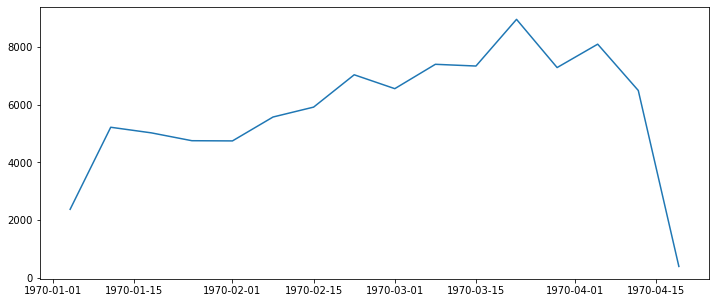

In [14]:
plt.figure(figsize=(12, 5))
plt.plot(weekly)

Here it appears that the peak we saw monthly is not as significant as the peak we see during a week in mid-March with over 8000 counts. We are able to see some of April's data now better by viewing it weekly. As a result, we can now see that in the 2nd week of April is the second highest peak in the timespan.

In [15]:
#compute daily to get weekday
daily = logins.resample('1D').sum()

In [16]:
week_day = daily.reset_index().copy()
week_day['day'] = week_day['login_time'].dt.dayofweek
week_day

,login_time,counts,day
0,1970-01-01,112,3
1,1970-01-02,681,4
2,1970-01-03,793,5
3,1970-01-04,788,6
4,1970-01-05,459,0
...,...,...,...
98,1970-04-09,818,3
99,1970-04-10,1009,4
100,1970-04-11,1352,5
101,1970-04-12,1409,6


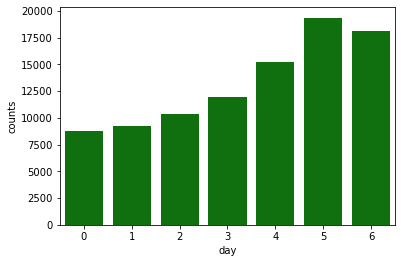

In [17]:
week = week_day.groupby('day').sum()
sns.barplot(x = week.index, y=week['counts'], color='g')

There are 103 days within this timespan. We know Monday = 0 and Sunday = 6. Additionally, we can see from the barplot that logins peak from Friday to Sunday which is the weekend.

In [18]:
hourly = logins.resample('H').sum().reset_index()
hourly

,login_time,counts
0,1970-01-01 20:00:00,24
1,1970-01-01 21:00:00,9
2,1970-01-01 22:00:00,21
3,1970-01-01 23:00:00,58
4,1970-01-02 00:00:00,53
...,...,...
2442,1970-04-13 14:00:00,32
2443,1970-04-13 15:00:00,19
2444,1970-04-13 16:00:00,22
2445,1970-04-13 17:00:00,22


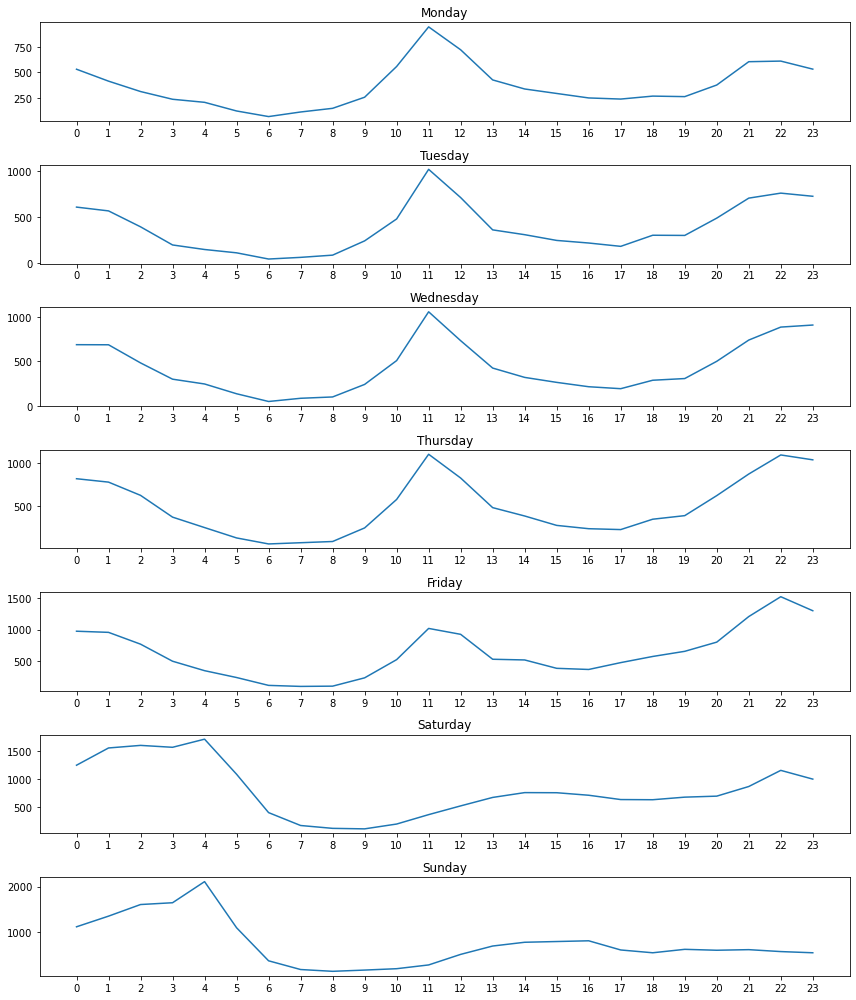

In [19]:
hourly['hour'] = hourly['login_time'].dt.hour
hourly['day'] = hourly['login_time'].dt.dayofweek
hourly_by_day = hourly.groupby(['day', 'hour']).sum().reset_index()

weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

fig, ax = plt.subplots(nrows=7, figsize=(12, 14))

for i in range(7):
    ax[i].plot(hourly_by_day.loc[hourly_by_day['day'] == i, ['hour', 'counts']].set_index('hour'))
    ax[i].set_title(weekdays[i])
    ax[i].set_xticks(np.arange(24))
    
plt.tight_layout()

## Conclusions

Demand is greatest in the month of March and specifically during the week at between 11am and 12pm during the day and then between 10pm to midnight in the evening. Monday through Friday also see their lowest activity around 7am. Saturday and Sunday have a different trend of demand with peak activity at 4am and then again after 11pm. Monday overall has the lowest activity with Friday through Sunday with the highest, especially Saturday.

# Part 2 ‑ Experiment and Metrics Design

### Question 1: What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

Assuming here, that a "driver partner" is different from other civilian drivers. Let's say a taxi driver is an example of a driver partner. Then the key measure of success for this experiment would be a metric that accurately captures the tendency of a driver partner to serve one city exclusively over the other (a sort of logged driver activity). This form of metric is best because since these are major cities their is public data on transportation and routes. Therefore, we should be able to know the percentage of drivers currently that cross the toll bridge and in whhich direction. Additionally, using say license plates as a unique indicator, there is now te ability to log which direction or to say away from which city the driver partner tends to serve more often. Once this is in place, if revenue is another goal for this experiment, then the current toll bridge activity can be used as a baseline (no toll reimbursment) and then when the reimbursment plan begins, or maybe something completely different, it can be targeted specifically toward which city driver partners it needs to enourage after seeing the refults of the experiment.

### Question 2: Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. 

#a.how you will implement the experiment
To implement this experiment I would set it up as a classification problem where X represented one city and y the other and the trips between are tracked. Trips would be defined as what city a driver left from and the city the driver returned to that day. From there, I would group the daily trips of driver partners into features such as number of trips that start and end in y city and then vice versa for  X city, number of trips that start in y city but end in X city, and number of trips that start in X city and end in y city. From here the average could be applied to see which feature and therefore, city is favored and then from there the reimbursment plan can be strategic in what portion of the target population it will address.

#b. what statistical tests
I think it would be best to apply A/B Testing where half of the driver partners (randomly chosen) are offered participation in this experiment and the other half are not (control condition). With this method, there are multiple means of comparison to observe the success (metric records for drivers before and after the experiment.

#c.how to interpret results and recommendations to city
Testing the null-hypothesis should be as simple as comparing the before and after ratios of both the testing group and control group with a two-way z-test to compare the means of the group, provided that all results for all groups are normally distributed (in the event that they are not, a non-parametric test should be utilized instead according to the distribution and standard deviation of the samples).

As for recommendations, I would suggest this tact be reviewed at least yearly, since changes in the population and economic conditions could cause a drastic change in the model. 

# Part 3 - Predictive Modeling

In [20]:
challenge.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [21]:
challenge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [22]:
challenge['avg_rating_by_driver'].fillna(challenge['avg_rating_by_driver'].median(), inplace=True)
challenge['avg_rating_of_driver'].fillna(challenge['avg_rating_of_driver'].median(), inplace=True)
challenge['phone'].fillna('Other', inplace=True)

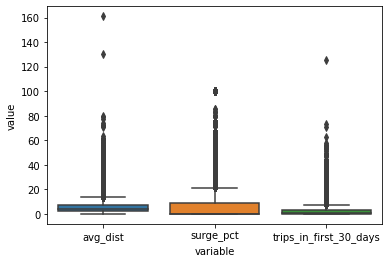

In [23]:
OUTLIERS = ['avg_dist', 'surge_pct', 'trips_in_first_30_days']
sns.boxplot(x="variable", y="value", data=pd.melt(challenge[OUTLIERS]))

In [24]:
# Replace the extreme values 
challenge.loc[challenge['avg_dist'] > 100, 'avg_dist'] = 80
challenge.loc[challenge['trips_in_first_30_days'] > 100, 'trips_in_first_30_days'] = 74

In [25]:
# Split the dataframe into active users and inactive users

active_users = challenge[challenge['trips_in_first_30_days'] > 0].copy()
inactive_users = challenge[challenge['trips_in_first_30_days'] == 0].copy()

In [26]:
print ('Active:   ', len(active_users))
print ('Inactive: ', len(inactive_users))

Active:    34610
Inactive:  15390


Approximately 30% of the users have become inactive.

In [27]:
# Convert the dtype of last_trip_date column to datetime
challenge['last_trip_date'] = pd.to_datetime(challenge['last_trip_date'])
challenge['signup_date'] = pd.to_datetime(challenge['signup_date'])

/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


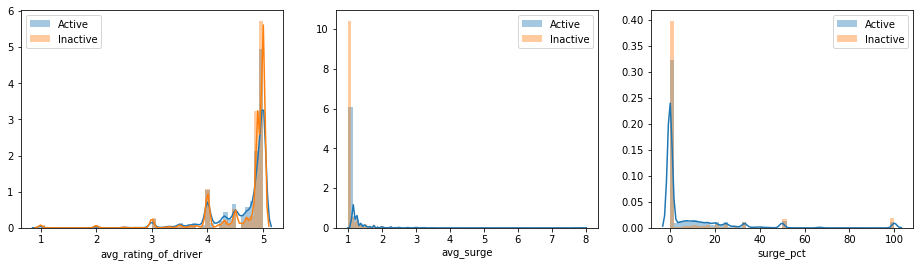

In [28]:
NUM = [col for col in challenge.columns if challenge[col].dtype == 'float64']
fig, ax = plt.subplots(ncols=3, figsize=(16, 4))

for i in range(3):
    sns.distplot(active_users[NUM[i]], ax=ax[i], label='Active').legend()
    sns.distplot(inactive_users[NUM[i]], ax=ax[i], label='Inactive').legend()

The active and inactive users have no significant difference in their usage during the week.

In [29]:
# Create the target column
challenge['TARGET'] = challenge['trips_in_first_30_days'].apply(lambda x: 1 if x > 0 else 0)

# Create the start_week column
challenge['start_week'] = challenge['signup_date'].dt.weekofyear

# Create the start_month column
challenge['start_month'] = challenge['signup_date'].dt.month

# Create the start_weekday column
challenge['start_weekday'] = challenge['signup_date'].dt.dayofweek

# Drop the trips_in_first_30_days column
challenge.drop(['trips_in_first_30_days', 'last_trip_date', 'signup_date'], axis=1, inplace=True)

In [30]:
CATEGORICAL = [col for col in challenge.columns if col not in NUM]

# Remove the target column from the list
CATEGORICAL.remove('TARGET')

# Sanity check that all columns are in a list except target
assert (len(CATEGORICAL) + len(NUM) == len(challenge.columns) - 1)

In [31]:
X = challenge.drop('TARGET', axis=1)
y = challenge['TARGET']

In [32]:
NUMERICAL_X_train = StandardScaler().fit_transform(X[NUM])
NUMERICAL_df = pd.DataFrame(NUMERICAL_X_train, columns=NUM)

In [33]:
CATEGORICAL_df = X[CATEGORICAL]

# Create dummy variables for the categorical variables
for col in CATEGORICAL:
    group_dummies = pd.get_dummies(CATEGORICAL_df[col]).rename(columns=lambda x: col + str(x))
    CATEGORICAL_df = CATEGORICAL_df.join(group_dummies)
    del CATEGORICAL_df[col]

In [34]:
concat_X = pd.concat([NUMERICAL_df, CATEGORICAL_df], axis=1)

In [35]:
rf = RandomForestClassifier().fit(concat_X, y)

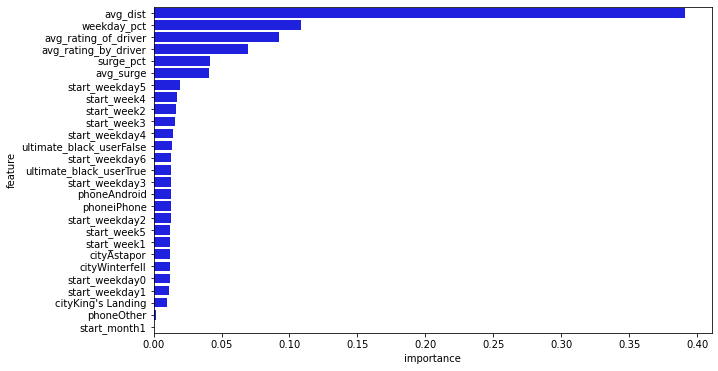

In [36]:
importances = rf.feature_importances_
features = pd.DataFrame({'feature': concat_X.columns, 'importance': importances})
features.sort_values(by='importance', ascending=False, inplace=True)

# Display a horizontal barplot with the feature importances
plt.figure(figsize=(10,6))
sns.barplot(x=features['importance'], y=features['feature'], color='blue', orient='h')

In [37]:
X_train, X_test, y_train, y_test = train_test_split(concat_X, y, test_size=0.2)

In [38]:
rf = RandomForestClassifier(n_estimators=100)

# Fit the Pipeline with the training data
rf.fit(X_train, y_train)

RandomForestClassifier()

In [39]:
predicted_train_values = rf.predict_proba(X_train)[:, -1]
predicted_test_values = rf.predict_proba(X_test)[:, -1]

# Print the scores
print (roc_auc_score(y_test, predicted_test_values))

0.6573291795278174


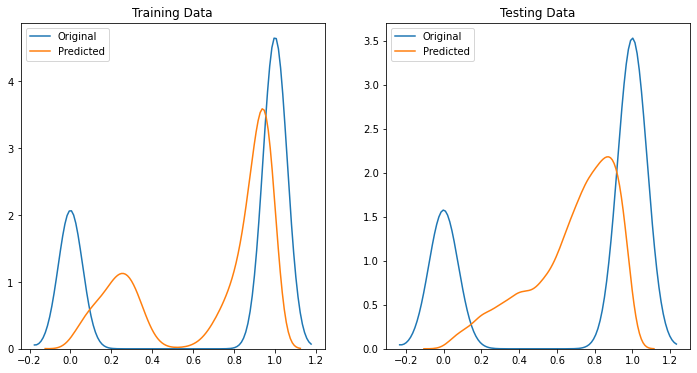

In [40]:
# Define the figure
fig, ax = plt.subplots(ncols=2, figsize=(12,6))

# Plot the training data
sns.kdeplot(y_train, ax=ax[0], label='Original').set_title('Training Data')
sns.kdeplot(predicted_train_values, ax=ax[0], label='Predicted')

# Plot the test data
sns.kdeplot(y_test, ax=ax[1], label='Original').set_title('Testing Data')
sns.kdeplot(predicted_test_values, ax=ax[1], label='Predicted')

I used RandomForest over let's say LogisticRegression because decison tree basd models are better at non-linear predictions, especially in the case of this project problem.

To retain more active users, I believe Ultimate should reduce either reduce the surge hours or reduce the surge multiplier. By reducing the surge hours this would have a stronger effect, since it had a higher feature importance and users are often deterred by any form of price multiplier. Also, I would encourage the use of Ultimate during the weekday through some sort of incentive. Also, an actionable insight here for Ultimate would be to target those users who experience no difference in their need for transportation between the week and the weekend. Those users are retained most.